## Elena Analysis

In [64]:
import pandas as pd
SOURCE_PATH = "/srv/workspace/research/user_based_contexts_tagging/matrices/"
gt = pd.read_csv(SOURCE_PATH + 'embeddings_groundtruth.csv')
predu = pd.read_csv(SOURCE_PATH + 'embeddings_predictions.csv')
preda = pd.read_csv(SOURCE_PATH + 'audio_predictions.csv')

import collections
counts = collections.Counter(gt['user_id'])
selected = [k for k in counts if counts[k] >= 10]

gt2 = gt.loc[gt.user_id.isin(selected)]
predu2 = predu.loc[predu.user_id.isin(selected)]
preda2 = preda.loc[preda.user_id.isin(selected)]

import numpy as np
from sklearn.metrics import roc_auc_score

cols = list(gt.columns)
cols.remove('user_id')
cols.remove('song_id')

per_user_ue = {}
per_user_a = {}
uu = np.unique(gt2.user_id)
for u in uu:
    gt3 = gt2.loc[gt.user_id == u]
    preda3 = preda2.loc[preda2.user_id == u]
    predu3 = predu2.loc[predu2.user_id == u]
    per_user_ue[u] =  roc_auc_score(gt3[cols].to_numpy(), predu3[cols].to_numpy(), average='micro')
    per_user_a[u] = roc_auc_score(gt3[cols].to_numpy(), preda3[cols].to_numpy(), average='micro')

bestus = set()
for u in uu:
    if per_user_ue[u] > per_user_a[u]:
        bestus.add(u)
worstus = set(gt2.user_id) - bestus

gt2bus = gt2.loc[gt2.user_id.isin(bestus)]
gt2wus = gt2.loc[gt2.user_id.isin(worstus)]
predu2bus = predu2.loc[predu2.user_id.isin(bestus)]
predu2wus = predu2.loc[predu2.user_id.isin(worstus)]
preda2bus = preda2.loc[preda2.user_id.isin(bestus)]
preda2wus = preda2.loc[preda2.user_id.isin(worstus)]

print('Best users')
res = roc_auc_score(gt2bus[cols].to_numpy(), preda2bus[cols].to_numpy(), average=None)
print("Audio", dict(zip(cols, res)))
res = roc_auc_score(gt2bus[cols].to_numpy(), predu2bus[cols].to_numpy(), average=None)
print("User emb", dict(zip(cols, res)), '\n')

print('Worst users')
res = roc_auc_score(gt2wus[cols].to_numpy(), preda2wus[cols].to_numpy(), average=None)
print("Audio", dict(zip(cols, res)))
res = roc_auc_score(gt2wus[cols].to_numpy(), predu2wus[cols].to_numpy(), average=None)
print("User emb", dict(zip(cols, res)))

with open("improved_user_ids", 'w') as _:
    for u in bestus:
        _.write(str(u) + '\n')

Best users
Audio {'car': 0.5142454099230833, 'gym': 0.574987318276199, 'happy': 0.5186283994786486, 'night': 0.6359856239847952, 'relax': 0.7965153578022197, 'running': 0.5710960282236809, 'sad': 0.7483963953089345, 'summer': 0.509440080060045, 'work': 0.5769329882082255, 'workout': 0.6945116478189721}
User emb {'car': 0.5350667522892952, 'gym': 0.5857307182975482, 'happy': 0.5704109201015861, 'night': 0.641541396540801, 'relax': 0.7824268922178921, 'running': 0.5643847283109906, 'sad': 0.7462339560523247, 'summer': 0.5257147146073841, 'work': 0.6483954704766919, 'workout': 0.6926264518225853} 

Worst users
Audio {'car': 0.5679303276043239, 'gym': 0.6135933676090402, 'happy': 0.5338379504660786, 'night': 0.5568642342196094, 'relax': 0.7003702164691681, 'running': 0.6323428526283291, 'sad': 0.729999421916685, 'summer': 0.5653391569967865, 'work': 0.48670061516607077, 'workout': 0.6534182998693505}
User emb {'car': 0.4733136465103253, 'gym': 0.6031961202928722, 'happy': 0.541042703835676

## Get embeddings and project

In [2]:
# load embeddings
embeddings = pd.read_pickle("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/user_embeddings.pkl")

In [39]:
bestus_ints = [int(k) for k in bestus]
best_embeds = embeddings[embeddings.user_id.isin(bestus_ints)]

worstus_ints = [int(k) for k in worstus]
worst_embeds = embeddings[embeddings.user_id.isin(worstus_ints)]

In [100]:
# create embeds matrices for projection
worst_embeds_matrix = np.zeros([len(worstus_ints),256])
for counter , x in enumerate(worst_embeds.features.values):
    worst_embeds_matrix[counter] = np.array(x)
worst_df = pd.DataFrame(worst_embeds_matrix)
worst_df['user_id'] = worstus_ints
worst_df['group'] = "Worst"
    
best_embeds_matrix = np.zeros([len(bestus_ints),256])
for counter , x in enumerate(best_embeds.features.values):
    best_embeds_matrix[counter] = np.array(x)
best_df = pd.DataFrame(best_embeds_matrix)
best_df['user_id'] = bestus_ints
best_df['group'] = "Best"
    
all_users_df = pd.concat([worst_df,best_df])

In [143]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(all_users_df.iloc[:,:-2])
principalComponents_df = pd.DataFrame(principalComponents,
                                      columns = ['principal component 1','principal component 2'])
principalComponents_df['user_id'] = all_users_df.user_id.values
principalComponents_df['group'] = all_users_df.group.values

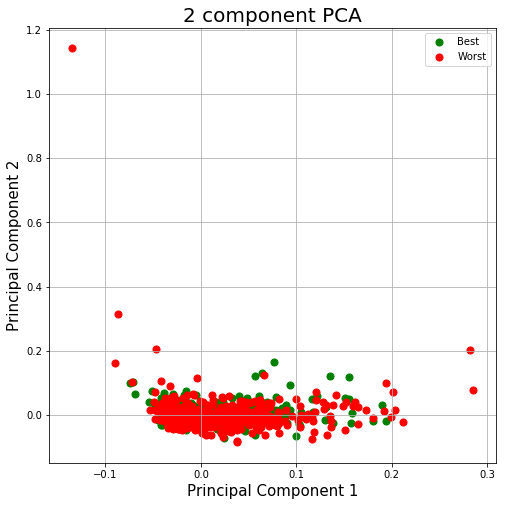

In [144]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Best', 'Worst']
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalComponents_df['group'] == target
    ax.scatter(principalComponents_df.loc[indicesToKeep, 'principal component 1']
               , principalComponents_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [141]:
# using TSNE 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_users_df.iloc[:,:-2])
tsne_df = pd.DataFrame(tsne_results,
                                      columns = ['Dim 1','Dim 2'])
tsne_df['user_id'] = all_users_df.user_id.values
tsne_df['group'] = all_users_df.group.values

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1399 samples in 0.005s...
[t-SNE] Computed neighbors for 1399 samples in 0.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1399
[t-SNE] Computed conditional probabilities for sample 1399 / 1399
[t-SNE] Mean sigma: 0.015312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.025352
[t-SNE] KL divergence after 300 iterations: 2.164780


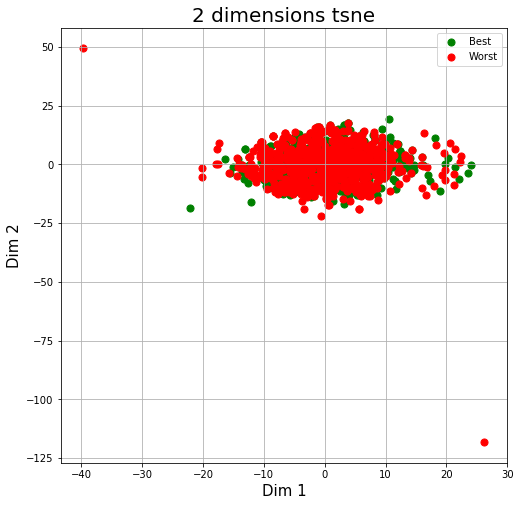

In [142]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.set_title('2 dimensions tsne', fontsize = 20)
targets = ['Best', 'Worst']
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_df['group'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 'Dim 1']
               , tsne_df.loc[indicesToKeep, 'Dim 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [131]:
# find outlier 
tsne_df.iloc[(list(tsne_results[:,1] > 60)).index(True),:]

Dim 1        -52.0888
Dim 2         77.8416
user_id    1709515222
group           Worst
Name: 172, dtype: object

In [138]:
# using TSNE without the outlier
all_users_outlierRemoved = all_users_df.drop(172,axis = 0)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_users_outlierRemoved.iloc[:,:-2])
tsne_df = pd.DataFrame(tsne_results,
                                      columns = ['Dim 1','Dim 2'])
tsne_df['user_id'] = all_users_outlierRemoved.user_id.values
tsne_df['group'] = all_users_outlierRemoved.group.values

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1397 samples in 0.009s...
[t-SNE] Computed neighbors for 1397 samples in 0.783s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1397
[t-SNE] Computed conditional probabilities for sample 1397 / 1397
[t-SNE] Mean sigma: 0.015454
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.805130
[t-SNE] KL divergence after 300 iterations: 2.277122


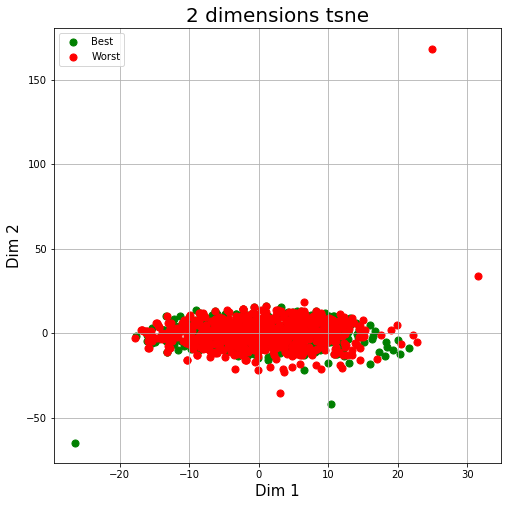

In [140]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.set_title('2 dimensions tsne', fontsize = 20)
targets = ['Best', 'Worst']
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_df['group'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 'Dim 1']
               , tsne_df.loc[indicesToKeep, 'Dim 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Checking the tracks

In [1]:
import pandas as pd
import numpy as np
from itertools import compress
from sklearn.metrics import cohen_kappa_score,f1_score,accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, \
    hamming_loss

SOURCE_PATH = "/srv/workspace/research/user_based_contexts_tagging/matrices/"
gt = pd.read_csv(SOURCE_PATH + 'embeddings_groundtruth.csv')
predu = pd.read_csv(SOURCE_PATH + 'embeddings_predictions.csv')
preda = pd.read_csv(SOURCE_PATH + 'audio_predictions.csv')

# create a frame of NAs 
LABELS_LIST = ['car', 'gym', 'happy', 'night', 'relax',
    'running', 'sad', 'summer', 'work', 'workout']
users_audio_f1 = pd.DataFrame(gt.user_id.unique(),columns = ["user_id"])
users_embeds_f1 = pd.DataFrame(gt.user_id.unique(),columns = ["user_id"])
users_audio_recall = pd.DataFrame(gt.user_id.unique(),columns = ["user_id"])
users_embeds_recall = pd.DataFrame(gt.user_id.unique(),columns = ["user_id"])
for x in LABELS_LIST:
    users_audio_f1[x] = np.NAN
    users_embeds_f1[x] = np.NAN
    users_audio_recall[x] = np.NAN
    users_embeds_recall[x] = np.NAN
users_audio_f1 = users_audio_f1.set_index("user_id")
users_embeds_f1 = users_embeds_f1.set_index("user_id")
users_audio_recall = users_audio_recall.set_index("user_id")
users_embeds_recall = users_embeds_recall.set_index("user_id")

# compute scores for only present labels
for user in users_audio_f1.index:
    user_truth = gt[gt.user_id == user]
    user_preds_audio = preda.loc[preda.user_id == user]
    user_preds_embeds = predu.loc[predu.user_id == user]
    active_labels_idx = user_truth.sum() > 0
    active_labels_idx = active_labels_idx[2:]
    active_labels = list(compress(LABELS_LIST, active_labels_idx))
    for label in active_labels:
        users_audio_f1.loc[user][label] = f1_score(user_truth[label],np.round(user_preds_audio[label]))
        users_embeds_f1.loc[user][label] = f1_score(user_truth[label],np.round(user_preds_embeds[label]))
        users_audio_recall.loc[user][label] = recall_score(user_truth[label],np.round(user_preds_audio[label]))
        users_embeds_recall.loc[user][label] = recall_score(user_truth[label],np.round(user_preds_embeds[label]))
        
# averaging per user
user_audio_f1_mean = users_audio_f1.mean(axis=1)
user_embeds_f1_mean = users_embeds_f1.mean(axis=1)

bestus_f1 = set()
for user in users_audio_f1.index:
    if user_embeds_f1_mean[user] >= user_audio_f1_mean[user]:
        bestus_f1.add(user)
worstus_f1 = set(gt.user_id) - bestus_f1

users_audio_recall_mean = users_audio_recall.mean(axis=1)
user_embeds_recall_mean = users_embeds_recall.mean(axis=1)

bestus_recall = set()
for user in users_audio_f1.index:
    if user_embeds_recall_mean[user] >= users_audio_recall_mean[user]:
        bestus_recall.add(user)
worstus_recall = set(gt.user_id) - bestus_recall

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
# checking the labels
# averaging per label
label_audio_f1_mean = users_audio_f1.mean(axis=0)
label_embeds_f1_mean = users_embeds_f1.mean(axis=0)

bestlabels_f1 = set()
for label in LABELS_LIST:
    if label_embeds_f1_mean[label] >= label_audio_f1_mean[label]:
        bestlabels_f1.add(label)
worstlabels_f1 = set(LABELS_LIST) - bestlabels_f1

label_audio_recall_mean = users_audio_recall.mean(axis=0)
label_embeds_recall_mean = users_embeds_recall.mean(axis=0)

bestlabels_recall = set()
for label in LABELS_LIST:
    if label_embeds_recall_mean[label] > label_audio_recall_mean[label]:
        bestlabels_recall.add(label)
worst_label_recall = set(LABELS_LIST) - bestlabels_recall

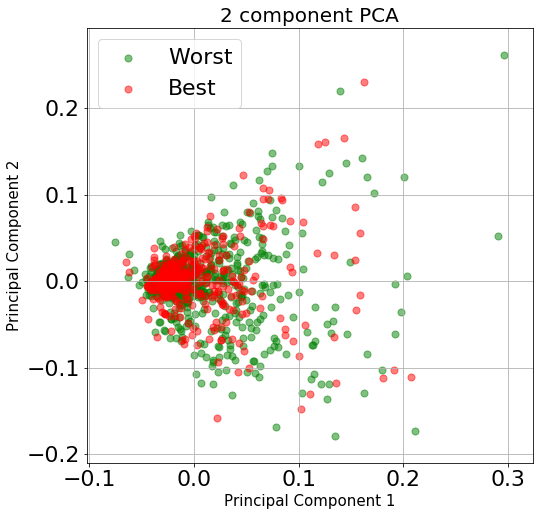

In [17]:
from sklearn.decomposition import PCA

bestus_ints = [int(k) for k in bestus_f1]
best_embeds = embeddings[embeddings.user_id.isin(bestus_ints)]

worstus_ints = [int(k) for k in worstus_f1]
worst_embeds = embeddings[embeddings.user_id.isin(worstus_ints)]
# create embeds matrices for projection
worst_embeds_matrix = np.zeros([len(worstus_ints),256])
for counter , x in enumerate(worst_embeds.features.values):
    worst_embeds_matrix[counter] = np.array(x)
worst_df = pd.DataFrame(worst_embeds_matrix)
worst_df['user_id'] = worstus_ints
worst_df['group'] = "Worst"
    
best_embeds_matrix = np.zeros([len(bestus_ints),256])
for counter , x in enumerate(best_embeds.features.values):
    best_embeds_matrix[counter] = np.array(x)
best_df = pd.DataFrame(best_embeds_matrix)
best_df['user_id'] = bestus_ints
best_df['group'] = "Best"
    
all_users_df = pd.concat([worst_df,best_df])

# find outlier and remove [NEED TO RUN PCA first]
"""
principalComponents_df.iloc[(list(principalComponents[:,0] > 0.25)).index(True),:]
all_users_outlierRemoved = all_users_df.drop(831,axis = 0)
"""

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(all_users_outlierRemoved.iloc[:,:-2])
principalComponents_df = pd.DataFrame(principalComponents,
                                      columns = ['principal component 1','principal component 2'])
principalComponents_df['user_id'] = all_users_outlierRemoved.user_id.values
principalComponents_df['group'] = all_users_outlierRemoved.group.values
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Worst','Best']
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalComponents_df['group'] == target
    ax.scatter(principalComponents_df.loc[indicesToKeep, 'principal component 1']
               , principalComponents_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha = 0.5)
ax.legend(targets)
ax.grid()

In [61]:
# Make dataframe comparing the f1 scores and recall per label
f1_comparison_df = pd.DataFrame(label_embeds_f1_mean,columns = ["Embeddings-based"])
f1_comparison_df['Audio-based'] = label_audio_f1_mean
f1_comparison_df["Difference"] = label_embeds_f1_mean - label_audio_f1_mean

In [62]:
f1_comparison_df

,Embeddings-based,Audio-based,Difference
car,0.574158,0.572356,0.001802
gym,0.599002,0.665382,-0.066380
happy,0.562183,0.341839,0.220344
night,0.398831,0.472292,-0.073461
relax,0.618980,0.701512,-0.082532
running,0.661303,0.648665,0.012638
sad,0.664879,0.692790,-0.027911
summer,0.609966,0.717959,-0.107993
work,0.648183,0.695552,-0.047369
workout,0.677581,0.596462,0.081119


In [51]:
best_users_labels = gt[gt.user_id.isin(bestus_f1)]
best_users_labels.drop('song_id', inplace = True,axis = 1)

worst_users_labels = gt[gt.user_id.isin(worstus_f1)]
worst_users_labels.drop('song_id', inplace = True,axis = 1)

print("average number of playlists per good user:" + str((best_users_labels.groupby("user_id").sum() > 0).sum(axis=1).mean()))
print("average number of playlists per bad user:" + str((worst_users_labels.groupby("user_id").sum() > 0).sum(axis=1).mean()))

average number of playlists per good user:1.735408560311284
average number of playlists per bad user:1.6591422121896162


In [79]:
gt2bus = gt2.loc[gt2.user_id.isin(bestus)]
gt2wus = gt2.loc[gt2.user_id.isin(worstus)]
predu2bus = predu2.loc[predu2.user_id.isin(bestus)]
predu2wus = predu2.loc[predu2.user_id.isin(worstus)]
preda2bus = preda2.loc[preda2.user_id.isin(bestus)]
preda2wus = preda2.loc[preda2.user_id.isin(worstus)]

print('Best users')
best_auc_embeds = roc_auc_score(gt2bus[cols].to_numpy(), preda2bus[cols].to_numpy(), average=None)
print("Audio", dict(zip(cols, res)))
best_auc_aud = roc_auc_score(gt2bus[cols].to_numpy(), predu2bus[cols].to_numpy(), average=None)
print("User emb", dict(zip(cols, res)), '\n')

print('Worst users')
worst_auc_embeds = roc_auc_score(gt2wus[cols].to_numpy(), preda2wus[cols].to_numpy(), average=None)
print("Audio", dict(zip(cols, res)))
worst_auc_aud = roc_auc_score(gt2wus[cols].to_numpy(), predu2wus[cols].to_numpy(), average=None)
print("User emb", dict(zip(cols, res)))


Best users
Audio {'car': 0.4733136465103253, 'gym': 0.6031961202928722, 'happy': 0.5410427038356767, 'night': 0.5584185295737105, 'relax': 0.6942320307177892, 'running': 0.6200583922439787, 'sad': 0.7274335839854311, 'summer': 0.5470805366092489, 'work': 0.40449482546217713, 'workout': 0.6417610055946511}
User emb {'car': 0.4733136465103253, 'gym': 0.6031961202928722, 'happy': 0.5410427038356767, 'night': 0.5584185295737105, 'relax': 0.6942320307177892, 'running': 0.6200583922439787, 'sad': 0.7274335839854311, 'summer': 0.5470805366092489, 'work': 0.40449482546217713, 'workout': 0.6417610055946511} 

Worst users
Audio {'car': 0.4733136465103253, 'gym': 0.6031961202928722, 'happy': 0.5410427038356767, 'night': 0.5584185295737105, 'relax': 0.6942320307177892, 'running': 0.6200583922439787, 'sad': 0.7274335839854311, 'summer': 0.5470805366092489, 'work': 0.40449482546217713, 'workout': 0.6417610055946511}
User emb {'car': 0.4733136465103253, 'gym': 0.6031961202928722, 'happy': 0.541042703

In [92]:
# make auc dataframes 
auc_best_df = pd.DataFrame(best_auc_embeds,columns = ["Embeddings-based"])
auc_best_df['Audio-based'] = best_auc_aud
auc_best_df["Difference"] = best_auc_embeds - best_auc_aud
auc_best_df.index = LABELS_LIST

In [93]:
# Make dataframe comparing the f1 scores and recall per label
auc_worst_df = pd.DataFrame(worst_auc_embeds,columns = ["Embeddings-based"])
auc_worst_df['Audio-based'] = worst_auc_aud
auc_worst_df["Difference"] = worst_auc_embeds - worst_auc_aud
auc_worst_df.index = LABELS_LIST

In [2]:
auc_best_df

NameError: name 'auc_best_df' is not defined